In [1]:
import numpy as np
import nibabel as nib
import glob
import pandas as pd
import random
import os

from matplotlib import pyplot as plt
from tifffile import imsave
from sklearn.preprocessing import MinMaxScaler

# Loading in the data

There are a few datasets:
* Dataset of images
* Dataset of mappings between images in this dataset and previous versions of the dataset
* Dataset of survival information of patient

In [2]:
TRAIN_DATASET_PATH = 'data/training/'

NAME_MAPPING_CSV = TRAIN_DATASET_PATH + 'name_mapping.csv'
train_df_nm = pd.read_csv(NAME_MAPPING_CSV)
train_df_nm.head(5)

,Grade,BraTS_2017_subject_ID,BraTS_2018_subject_ID,TCGA_TCIA_subject_ID,BraTS_2019_subject_ID,BraTS_2020_subject_ID
0,HGG,Brats17_CBICA_AAB_1,Brats18_CBICA_AAB_1,NaN,BraTS19_CBICA_AAB_1,BraTS20_Training_001
1,HGG,Brats17_CBICA_AAG_1,Brats18_CBICA_AAG_1,NaN,BraTS19_CBICA_AAG_1,BraTS20_Training_002
2,HGG,Brats17_CBICA_AAL_1,Brats18_CBICA_AAL_1,NaN,BraTS19_CBICA_AAL_1,BraTS20_Training_003
3,HGG,Brats17_CBICA_AAP_1,Brats18_CBICA_AAP_1,NaN,BraTS19_CBICA_AAP_1,BraTS20_Training_004
4,HGG,Brats17_CBICA_ABB_1,Brats18_CBICA_ABB_1,NaN,BraTS19_CBICA_ABB_1,BraTS20_Training_005


In [4]:
NAME_MAPPING_CSV = TRAIN_DATASET_PATH+'survival_info.csv'
train_df_si=pd.read_csv(NAME_MAPPING_CSV)
train_df_si.head(5)

,Brats20ID,Age,Survival_days,Extent_of_Resection
0,BraTS20_Training_001,60.463,289,GTR
1,BraTS20_Training_002,52.263,616,GTR
2,BraTS20_Training_003,54.301,464,GTR
3,BraTS20_Training_004,39.068,788,GTR
4,BraTS20_Training_005,68.493,465,GTR


## Looking at some images

Image number 166
Image Shapes
Flair   (240, 240, 155)
T1      (240, 240, 155)
T1ce    (240, 240, 155)
T2      (240, 240, 155)
Mask    (240, 240, 155)


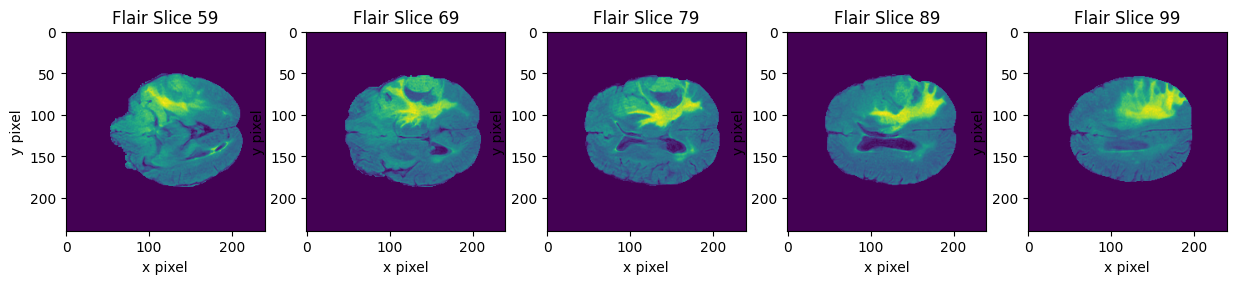

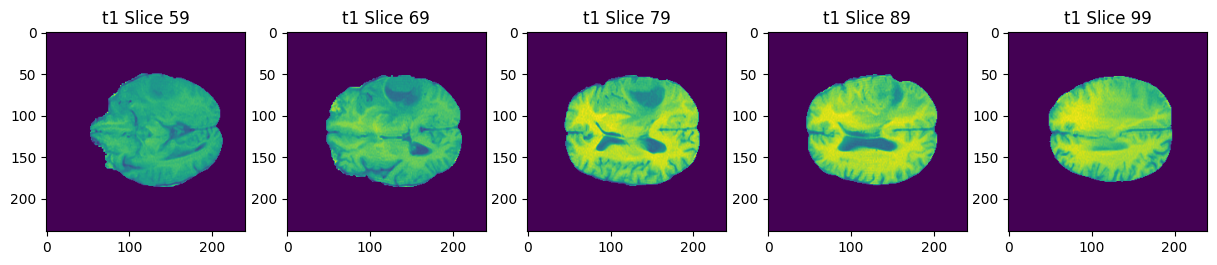

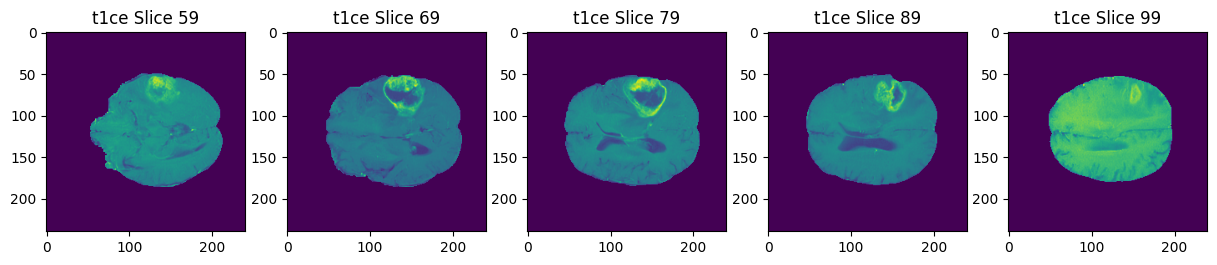

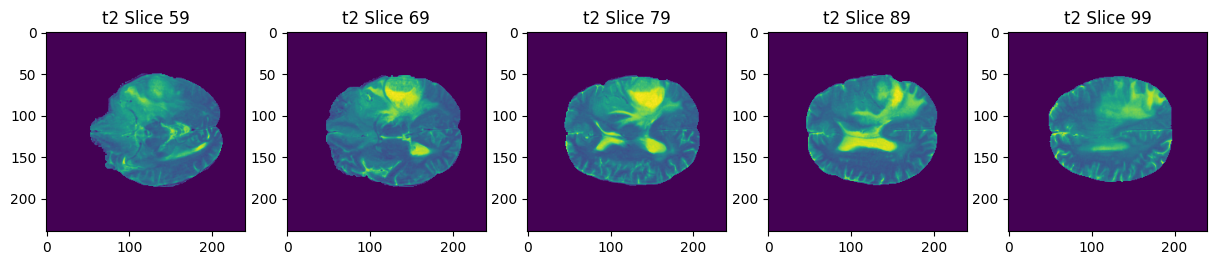

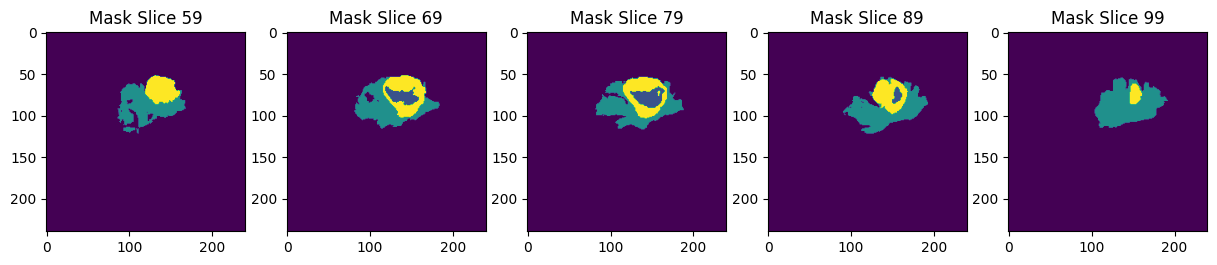

In [6]:
def visualize_subject(subject):

    print("Image number", subject)
    base_path = TRAIN_DATASET_PATH + 'BraTS20_Training_' + str(subject).zfill(3) + '/BraTS20_Training_' + str(subject).zfill(3)

    image_flair = nib.load(base_path + '_flair.nii').get_fdata()
    image_t1 = nib.load(base_path + '_t1.nii').get_fdata()
    image_t1ce = nib.load(base_path + '_t1ce.nii').get_fdata()
    image_t2 = nib.load(base_path + '_t2.nii').get_fdata()
    image_mask = nib.load(base_path + '_seg.nii').get_fdata()

    print("Image Shapes")
    print("Flair  ", image_flair.shape)
    print("T1     ", image_t1.shape)
    print("T1ce   ", image_t1ce.shape)
    print("T2     ", image_t2.shape)
    print("Mask   ", image_mask.shape)

    # test_image_flair[:,:,n_slice]
    for i in range(5):
        slice = 59 + i * 10

        plt.subplot(5, 5,i + 1)
        plt.title("Flair Slice " + str(slice))
        plt.xlabel("x pixel")
        plt.ylabel('y pixel')
        plt.imshow(image_flair[:,:,59 + i*10])
        plt.gcf().set_size_inches(15, 15)
    plt.show()

    for i in range(5):
        slice = 59 + i * 10
        plt.subplot(5, 5,i + 1)
        plt.title("t1 Slice " + str(slice))
        plt.imshow(image_t1[:,:,59 + i*10])
        plt.gcf().set_size_inches(15, 15)
    plt.show()

    for i in range(5):
        slice = 59 + i * 10
        plt.subplot(5, 5,i + 1)
        plt.title("t1ce Slice " + str(slice))
        plt.imshow(image_t1ce[:,:,59 + i*10])
        plt.gcf().set_size_inches(15, 15)
    plt.show()

    for i in range(5):
        slice = 59 + i * 10
        plt.subplot(5, 5,i + 1)
        plt.title("t2 Slice " + str(slice))
        plt.imshow(image_t2[:,:,59 + i*10])
        plt.gcf().set_size_inches(15, 15)
    plt.show()

    for i in range(5):
        slice = 59 + i * 10
        plt.subplot(5, 5,i + 1)
        plt.title("Mask Slice " + str(slice))
        plt.imshow(image_mask[:,:,59 + i*10])
        plt.gcf().set_size_inches(15, 15)
    plt.show()


visualize_subject(random.randint(0, 371))

## Validate File Presence
### Load all mri brain scans

In [8]:
t1_list = sorted(glob.glob(TRAIN_DATASET_PATH + '/*/*t1.nii'))
t2_list = sorted(glob.glob(TRAIN_DATASET_PATH + '/*/*t2.nii'))
t1ce_list = sorted(glob.glob(TRAIN_DATASET_PATH + '/*/*t1ce.nii'))
flair_list = sorted(glob.glob(TRAIN_DATASET_PATH + '/*/*flair.nii'))
mask_list = sorted(glob.glob(TRAIN_DATASET_PATH + '/*/*seg.nii'))
file_list = sorted(glob.glob(TRAIN_DATASET_PATH + '/*'))
brainFile_list = list(filter(lambda x: x[-3:]!='csv',file_list))

# are they the same?
print(len(brainFile_list))
print(len(t1_list))
print(len(t2_list))
print(len(t1ce_list))
print(len(flair_list))
print(len(mask_list))


369
369
369
369
369
369


### Find Missing mask file

In [9]:
# Looking for missing files
for brainFile in brainFile_list:
    if not os.path.isdir(brainFile):
        print("Skipping", brainFile)
        continue

    fileNum = brainFile[-3:]

    t1 = brainFile + '/BraTS20_Training_' + fileNum + '_t1.nii'
    t1ce = brainFile + '/BraTS20_Training_'+ fileNum + '_t1ce.nii'
    t2 = brainFile + '/BraTS20_Training_' + fileNum + '_t2.nii'
    flair = brainFile + '/BraTS20_Training_' + fileNum + '_flair.nii'
    mask = brainFile + '/BraTS20_Training_' + fileNum + '_seg.nii'

    if t1 not in t1_list:
        print(fileNum)
        print('t1 missing in '+fileNum)
        
    if t1ce not in t1ce_list:
        print('t1ce missing in '+fileNum)
    
    if t2 not in t2_list:
        print('t2 missing in '+fileNum)
    
    if flair not in flair_list:
        print('flair missing in '+fileNum)
    
    if mask not in mask_list:
        print('mask missing in '+fileNum)
        

## Analyze Mask labels

In [10]:
#No Label 3
mask_list_img_sample_list=np.array(list((map(lambda n: np.array(nib.load(n).dataobj), random.sample(mask_list, 5)))))
mask_np=mask_list_img_sample_list.reshape(-1)

print(np.unique(mask_np))
mask_np[mask_np==4] = 3 
print(np.unique(mask_np)) 

[0 1 2 4]
[0 1 2 3]


## Analyze Pixel distribution

In [16]:
#ANALYZING PIXEL VALUES

#converting sample of t1 images into list of numpy array
t1_img_sample_list=np.array(list((map(lambda n: np.array(nib.load(n).dataobj), random.sample(t1_list, 5)))))
t1ce_img_sample_list=np.array(list((map(lambda n: np.array(nib.load(n).dataobj), random.sample(t1ce_list, 5)))))
t2_img_sample_list=np.array(list((map(lambda n: np.array(nib.load(n).dataobj), random.sample(t2_list, 5)))))
flair_img_sample_list=np.array(list((map(lambda n: np.array(nib.load(n).dataobj), random.sample(flair_list, 5)))))

print(t1_img_sample_list.shape)

t1_np=t1_img_sample_list.reshape(-1)
t1ce_np=t1ce_img_sample_list.reshape(-1)
t2_np=t2_img_sample_list.reshape(-1)
flair_np=flair_img_sample_list.reshape(-1)


(5, 240, 240, 155)
(240, 240, 155)


/Users/alexwebster/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


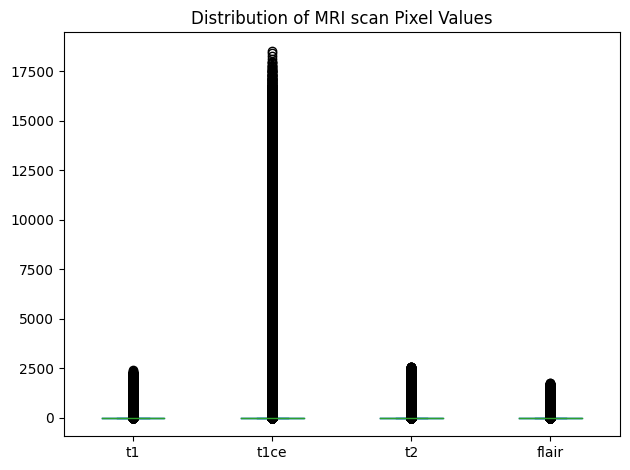

In [9]:
plt.rcParams["figure.autolayout"] = True
data = pd.DataFrame({"t1": t1_np, "t1ce": t1ce_np, "t2":t2_np, "flair":flair_np})
ax = data[['t1', 't1ce','t2','flair']].plot(kind='box', title='Distribution of MRI scan Pixel Values')

#plt.boxplot(nparray)
plt.show()

/Users/alexwebster/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


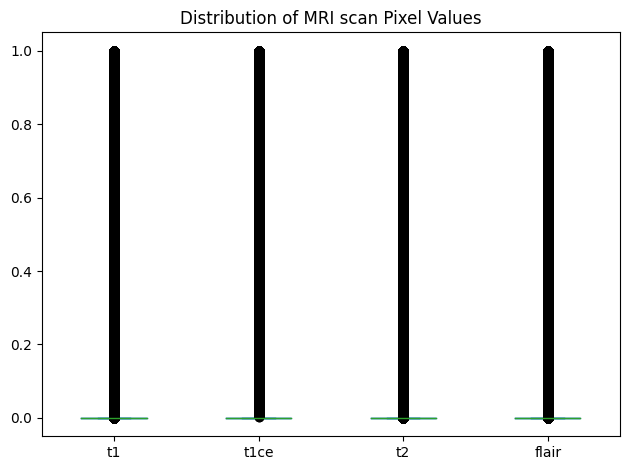

In [13]:
# Clearly this shows data needs to be normalized. Especially for training because higher pixel values are not necessarily more valuable
# Also because we will be stacking the images anmd inputting into the model we want the same range of values.

# Normalize using MinMax Scaler between 0 and 1
scaler = MinMaxScaler()
t1_img_sample_list = scaler.fit_transform(t1_img_sample_list.reshape(-1, t1_img_sample_list.shape[-1])).reshape(t1_img_sample_list.shape)
t1ce_img_sample_list = scaler.fit_transform(t1ce_img_sample_list.reshape(-1, t1ce_img_sample_list.shape[-1])).reshape(t1ce_img_sample_list.shape)
t2_img_sample_list = scaler.fit_transform(t2_img_sample_list.reshape(-1, t2_img_sample_list.shape[-1])).reshape(t2_img_sample_list.shape)
flair_img_sample_list = scaler.fit_transform(flair_img_sample_list.reshape(-1, flair_img_sample_list.shape[-1])).reshape(flair_img_sample_list.shape)

# Re-plot distribution
t1_np=t1_img_sample_list.reshape(-1)
t1ce_np=t1ce_img_sample_list.reshape(-1)
t2_np=t2_img_sample_list.reshape(-1)
flair_np=flair_img_sample_list.reshape(-1)

plt.rcParams["figure.autolayout"] = True
data = pd.DataFrame({"t1": t1_np, "t1ce": t1ce_np, "t2":t2_np, "flair":flair_np})
ax = data[['t1', 't1ce','t2','flair']].plot(kind='box', title='Distribution of MRI scan Pixel Values')

#plt.boxplot(nparray)
plt.show()

## Comparing Image Types

* We want to see if labeled pixels hold different values then unlabled pixels for each type
* Esentially, lets make sure theres actually information for us to use

In [5]:
scaler = MinMaxScaler()
def helper_append(array, data):
    for i in range(len(array)):
        array[i] = np.append(array[i], data[i])

def process(file, file_mask):
    image = nib.load(file).get_fdata()
    mask = nib.load(file_mask).get_fdata()

    image = image[56:184, 56:184, 13:141]
    mask = mask[56:184, 56:184, 13:141]

    image = scaler.fit_transform(image.reshape(-1, image.shape[-1])).reshape(image.shape)
    
    f_image = image.reshape(-1)
    f_mask = mask.reshape(-1)
    
    return f_image[f_mask == 0], f_image[f_mask == 1], f_image[f_mask == 2], f_image[f_mask == 4]

sample_size = 369*0.15
n = 128*128*128 * sample_size
t1_flat_grouped = [np.array([]), np.array([]), np.array([]), np.array([])]
t1ce_flat_grouped = [np.array([]), np.array([]), np.array([]), np.array([])]
t2_flat_grouped = [np.array([]), np.array([]), np.array([]), np.array([])]
flair_flat_grouped = [np.array([]), np.array([]), np.array([]), np.array([])]

# t1_labelled, t1_not_labelled = np.array([]), np.array([])
t1ce_labelled, t1ce_not_labelled = np.zeros([]), np.zeros([])
t2_labelled, t2_not_labelled = np.zeros([]), np.zeros([])
flair_labelled, flair_not_labelled = np.array([]), np.array([])

base = TRAIN_DATASET_PATH + "/BraTS20_Training_"
count = -1
for _ in range(int(sample_size)):
    sample = random.randint(0, 369)

    fileNum = str(sample).zfill(3)

    t1 = base + fileNum + '/BraTS20_Training_' + fileNum + '_t1.nii'
    t1ce = base + fileNum + '/BraTS20_Training_'+ fileNum + '_t1ce.nii'
    t2 = base + fileNum + '/BraTS20_Training_' + fileNum + '_t2.nii'
    flair = base + fileNum + '/BraTS20_Training_' + fileNum + '_flair.nii'
    mask = base + fileNum + '/BraTS20_Training_' + fileNum + '_seg.nii'

    tmp = process(t1, mask)
    helper_append(t1_flat_grouped, tmp)

    tmp = process(t1ce, mask)
    helper_append(t1ce_flat_grouped, tmp)

    tmp = process(t2, mask)
    helper_append(t2_flat_grouped, tmp)

    tmp = process(flair, mask)
    helper_append(flair_flat_grouped, tmp)

print(len(t1_flat_grouped), len(t1_flat_grouped[0]), len(t1_flat_grouped[1]), len(t1_flat_grouped[2]), len(t1_flat_grouped[3]))


4 110306578 1227999 2719164 1089619


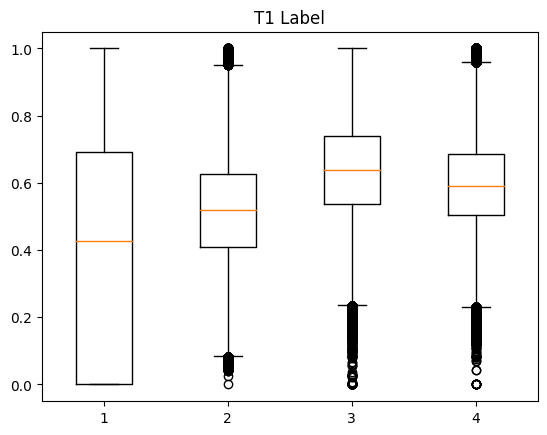

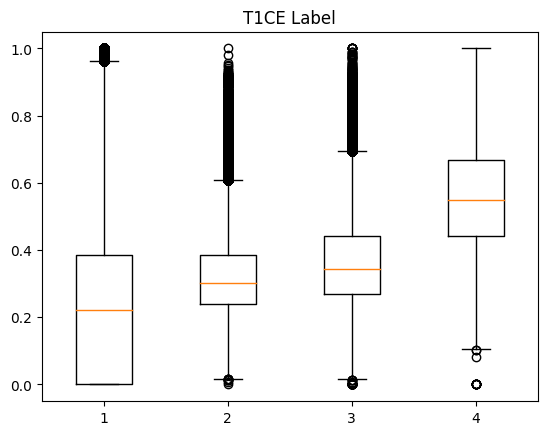

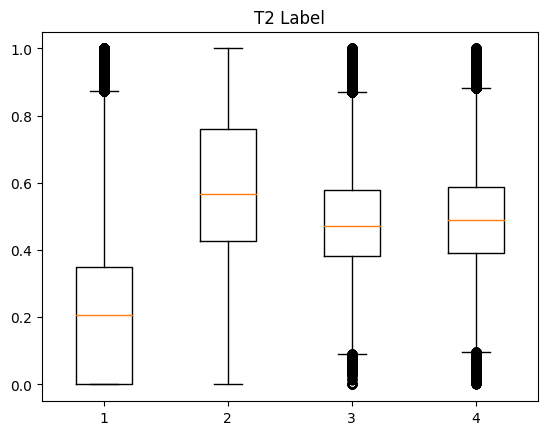

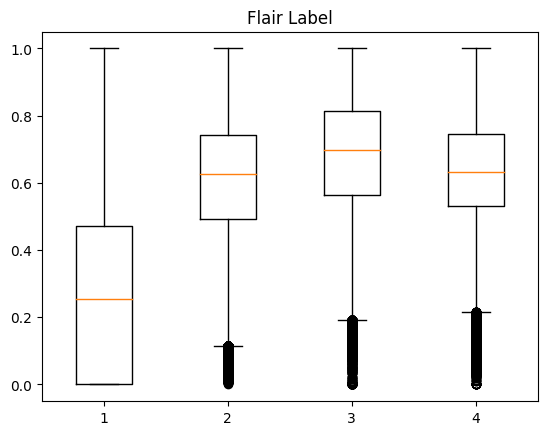

In [6]:
plt.title("T1 Label")
plt.boxplot(t1_flat_grouped, notch=None, vert=None, patch_artist=None, widths=None)
plt.show()

plt.title("T1CE Label")
plt.boxplot(t1ce_flat_grouped, notch=None, vert=None, patch_artist=None, widths=None)
plt.show()

plt.title("T2 Label")
plt.boxplot(t2_flat_grouped, notch=None, vert=None, patch_artist=None, widths=None)
plt.show()

plt.title("Flair Label")
plt.boxplot(flair_flat_grouped, notch=None, vert=None, patch_artist=None, widths=None)
plt.show()


In [ ]:
test_image_flair=scaler.fit_transform(test_image_flair.reshape(-1, test_image_flair.shape[-1])).reshape(test_image_flair.shape)
print(test_image_flair.max())
brainNumber='120'

test_image_t1=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_'+brainNumber+'/BraTS20_Training_'+brainNumber+'_t1.nii').get_fdata()
test_image_t1=scaler.fit_transform(test_image_t1.reshape(-1, test_image_t1.shape[-1])).reshape(test_image_t1.shape)

test_image_t1ce=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_'+brainNumber+'/BraTS20_Training_'+brainNumber+'_t1ce.nii').get_fdata()
test_image_t1ce=scaler.fit_transform(test_image_t1ce.reshape(-1, test_image_t1ce.shape[-1])).reshape(test_image_t1ce.shape)

test_image_t2=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_'+brainNumber+'/BraTS20_Training_'+brainNumber+'_t2.nii').get_fdata()
test_image_t2=scaler.fit_transform(test_image_t2.reshape(-1, test_image_t2.shape[-1])).reshape(test_image_t2.shape)

test_mask=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_'+brainNumber+'/BraTS20_Training_'+brainNumber+'_seg.nii').get_fdata()
test_mask=test_mask.astype(np.uint8)

In [ ]:
n_slice=random.randint(0, test_mask.shape[2])
m_slice=60
print(n_slice)
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.imshow(test_image_flair[:,:,n_slice], cmap='gray')
plt.title('Image flair')

plt.subplot(232)
plt.imshow(test_image_t1[:,:,n_slice], cmap='gray')
plt.title('Image t1')
plt.subplot(233)
plt.imshow(test_image_t1ce[:,:,n_slice], cmap='gray')
plt.title('Image t1ce')
plt.subplot(234)
plt.imshow(test_image_t2[:,:,n_slice], cmap='gray')
plt.title('Image t2')
plt.subplot(235)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')

plt.show()
